In [17]:
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
from pinder.core.loader import structure
from Processor import Processor
import numpy as np
from scipy.special import rel_entr

HOME = "/scicore/home/schwede/pudziu0000/"
PINDER_BASE_DIR="/scicore/home/schwede/durair0000/.local/share/"

def get_distances(data_file, emb_file):
    data = pd.read_csv(data_file, sep="\t")
    embs = torch.load(emb_file)
    embs = torch.squeeze(embs)
    embs = embs.to(torch.float64)
    
    # Separate embeddings: first 1280 dims are for R, the remaining for L
    r_embs = embs[:, :1280]
    l_embs = embs[:, 1280:]
    
    # Compute distances between embeddings of the pair
    dist_m = torch.cdist(r_embs, l_embs)
    distances = dist_m.diag()
    
    # Save distances into two collections: one for positive pairs, other for negative ones
    pos_mask = list(map(bool, data['label'].tolist()))
    neg_mask = list(map(bool, (1-data['label']).tolist()))
    
    pos_dists = distances[pos_mask]
    neg_dists = distances[neg_mask]

    return pos_dists, neg_dists

def plot_distributions(dist1, dist2, title):
    matplotlib.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(10, 5))

    hist1, _ = np.histogram(dist1, density=True)
    hist2, _ = np.histogram(dist2, density=True)
    
    plt.hist(dist1, color='red', alpha=0.5, label='positive')
    plt.hist(dist2, color='blue', alpha=0.5, label='negative')
    plt.xlabel('distance')
    plt.ylabel('frequency')
    plt.title(title)
    plt.legend()
    
    plt.show()

    return hist1, hist2

def compute_KL_divergence(hist1, hist2):
    # Clip to avoid division by zero and ensure valid inputs
    epsilon = 1e-10
    p1 = np.clip(hist1, epsilon, None)
    p2 = np.clip(hist2, epsilon, None)
    
    # Normalize histograms to make them proper probability distributions
    p1 /= p1.sum()
    p2 /= p2.sum()
    
    kl_12 = np.sum(rel_entr(p1, p2))
    kl_21 = np.sum(rel_entr(p2, p1))
    
    return kl_12, kl_21

def get_pinder_seq_data(data_file):
    df = pd.read_csv(data_file, sep="\t")
    
    ids = {"R": [], "L": []}
    for i, j in df.iterrows():
        idR = df["protein1"][i]
        idL = df["protein2"][i]
        ids["R"].append(idR)
        ids["L"].append(idL)

    seq_data = {}
    
    for i, id_ in enumerate(ids["R"]):
        struct_r = structure.Structure(f"{PINDER_BASE_DIR}/pinder/2024-02/pdbs/{id_}-R.pdb", pinder_id=id_)
        struct_l = structure.Structure(f"{PINDER_BASE_DIR}/pinder/2024-02/pdbs/{ids['L'][i]}-L.pdb", pinder_id=ids['L'][i])
        seq_data[id_] = struct_r.sequence
        seq_data[ids['L'][i]] = struct_l.sequence

    return seq_data

def get_seq_data(data_file, fasta_file):
    proc = Processor(fasta_file, data_file, "")
    return proc.load_fasta()

def get_homodimers_count(data_file, seq_data):
    data = pd.read_csv(data_file, sep="\t")

    homodimers_count = 0
    
    for index, row in data.iterrows():
        if(seq_data[row['protein1']] == seq_data[row['protein2']]):
            homodimers_count += 1
    
    return homodimers_count

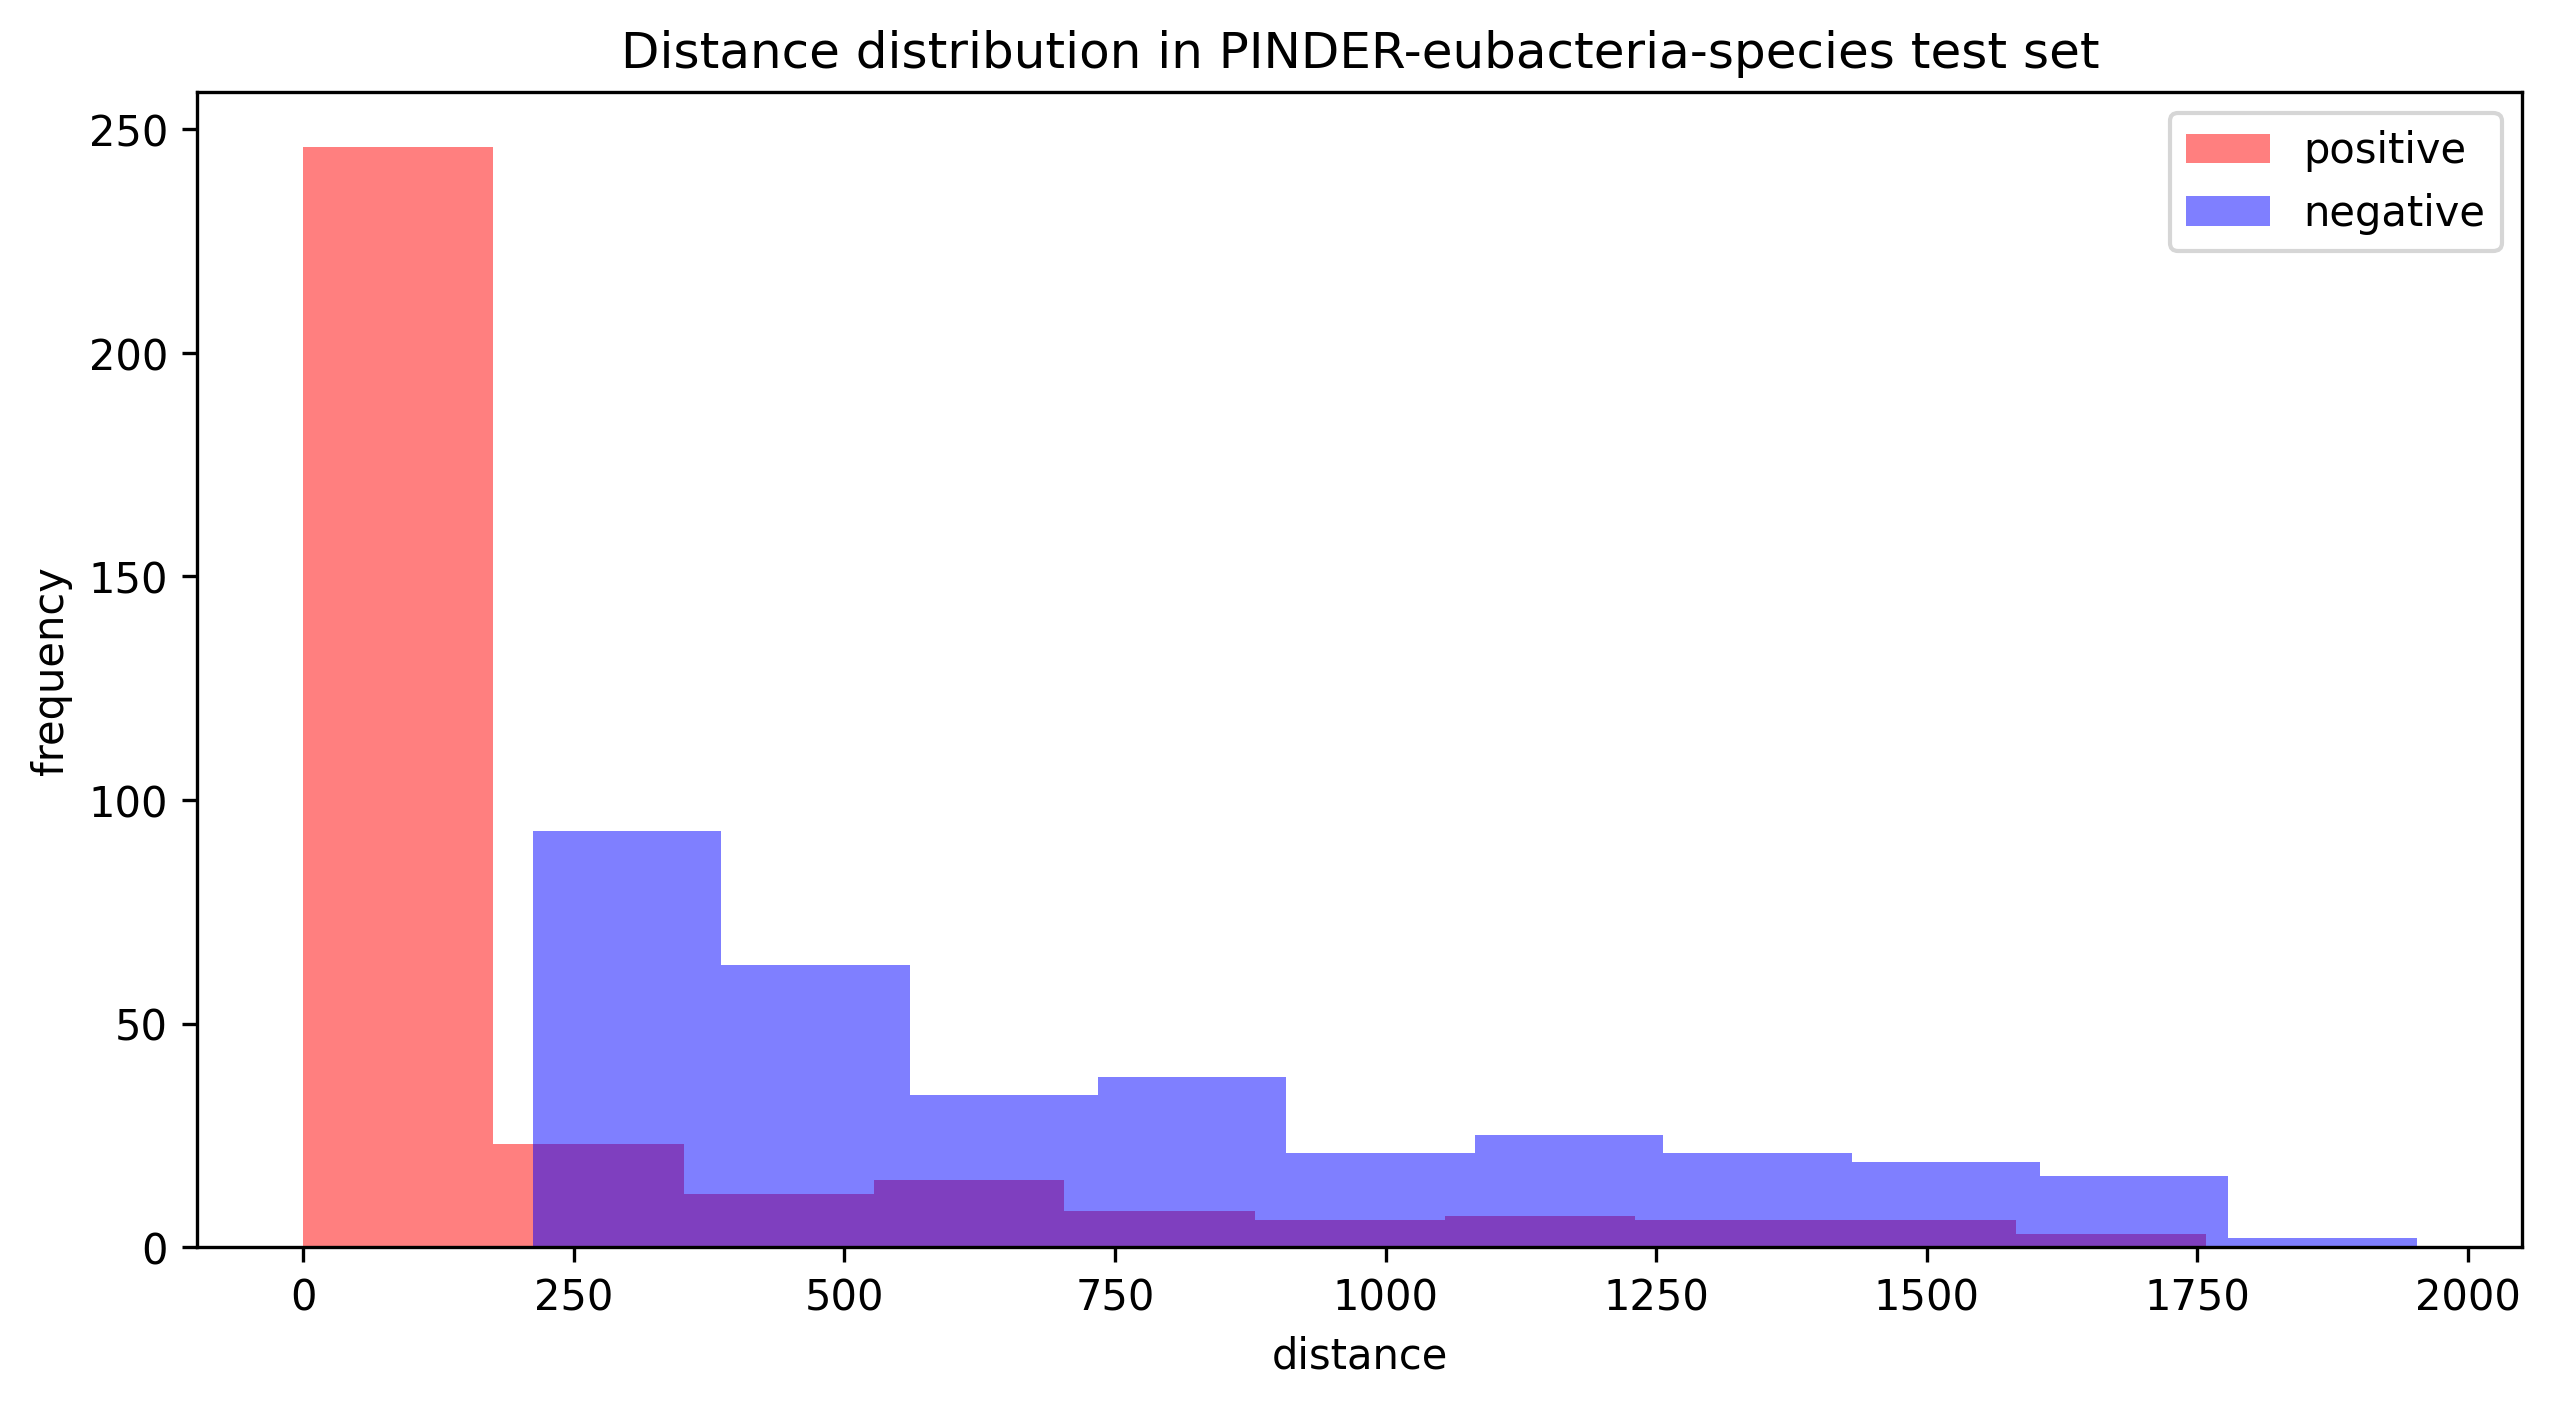

KL(1 | 0) divergence: 0.464
KL(0 | 1) divergence: 0.481


In [18]:
pinder_data_file = f"{HOME}/projects/gLM/data/PINDER/eubacteria_5_1024_512_species/test.txt"
pinder_emb_file = f"{HOME}/projects/gLM/embeddings/PINDER-eubacteria-species/gLM2_650M_sep/test.pt"

pinder_pos_dists, pinder_neg_dists = get_distances(pinder_data_file, pinder_emb_file)
pinder_hist_pos, pinder_hist_neg = plot_distributions(pinder_pos_dists, pinder_neg_dists, title="Distance distribution in PINDER-eubacteria-species test set")

kl_posneg, kl_negpos = compute_KL_divergence(pinder_hist_pos, pinder_hist_neg)
print(f"KL(1 | 0) divergence: {kl_posneg:.3f}\nKL(0 | 1) divergence: {kl_negpos:.3f}")

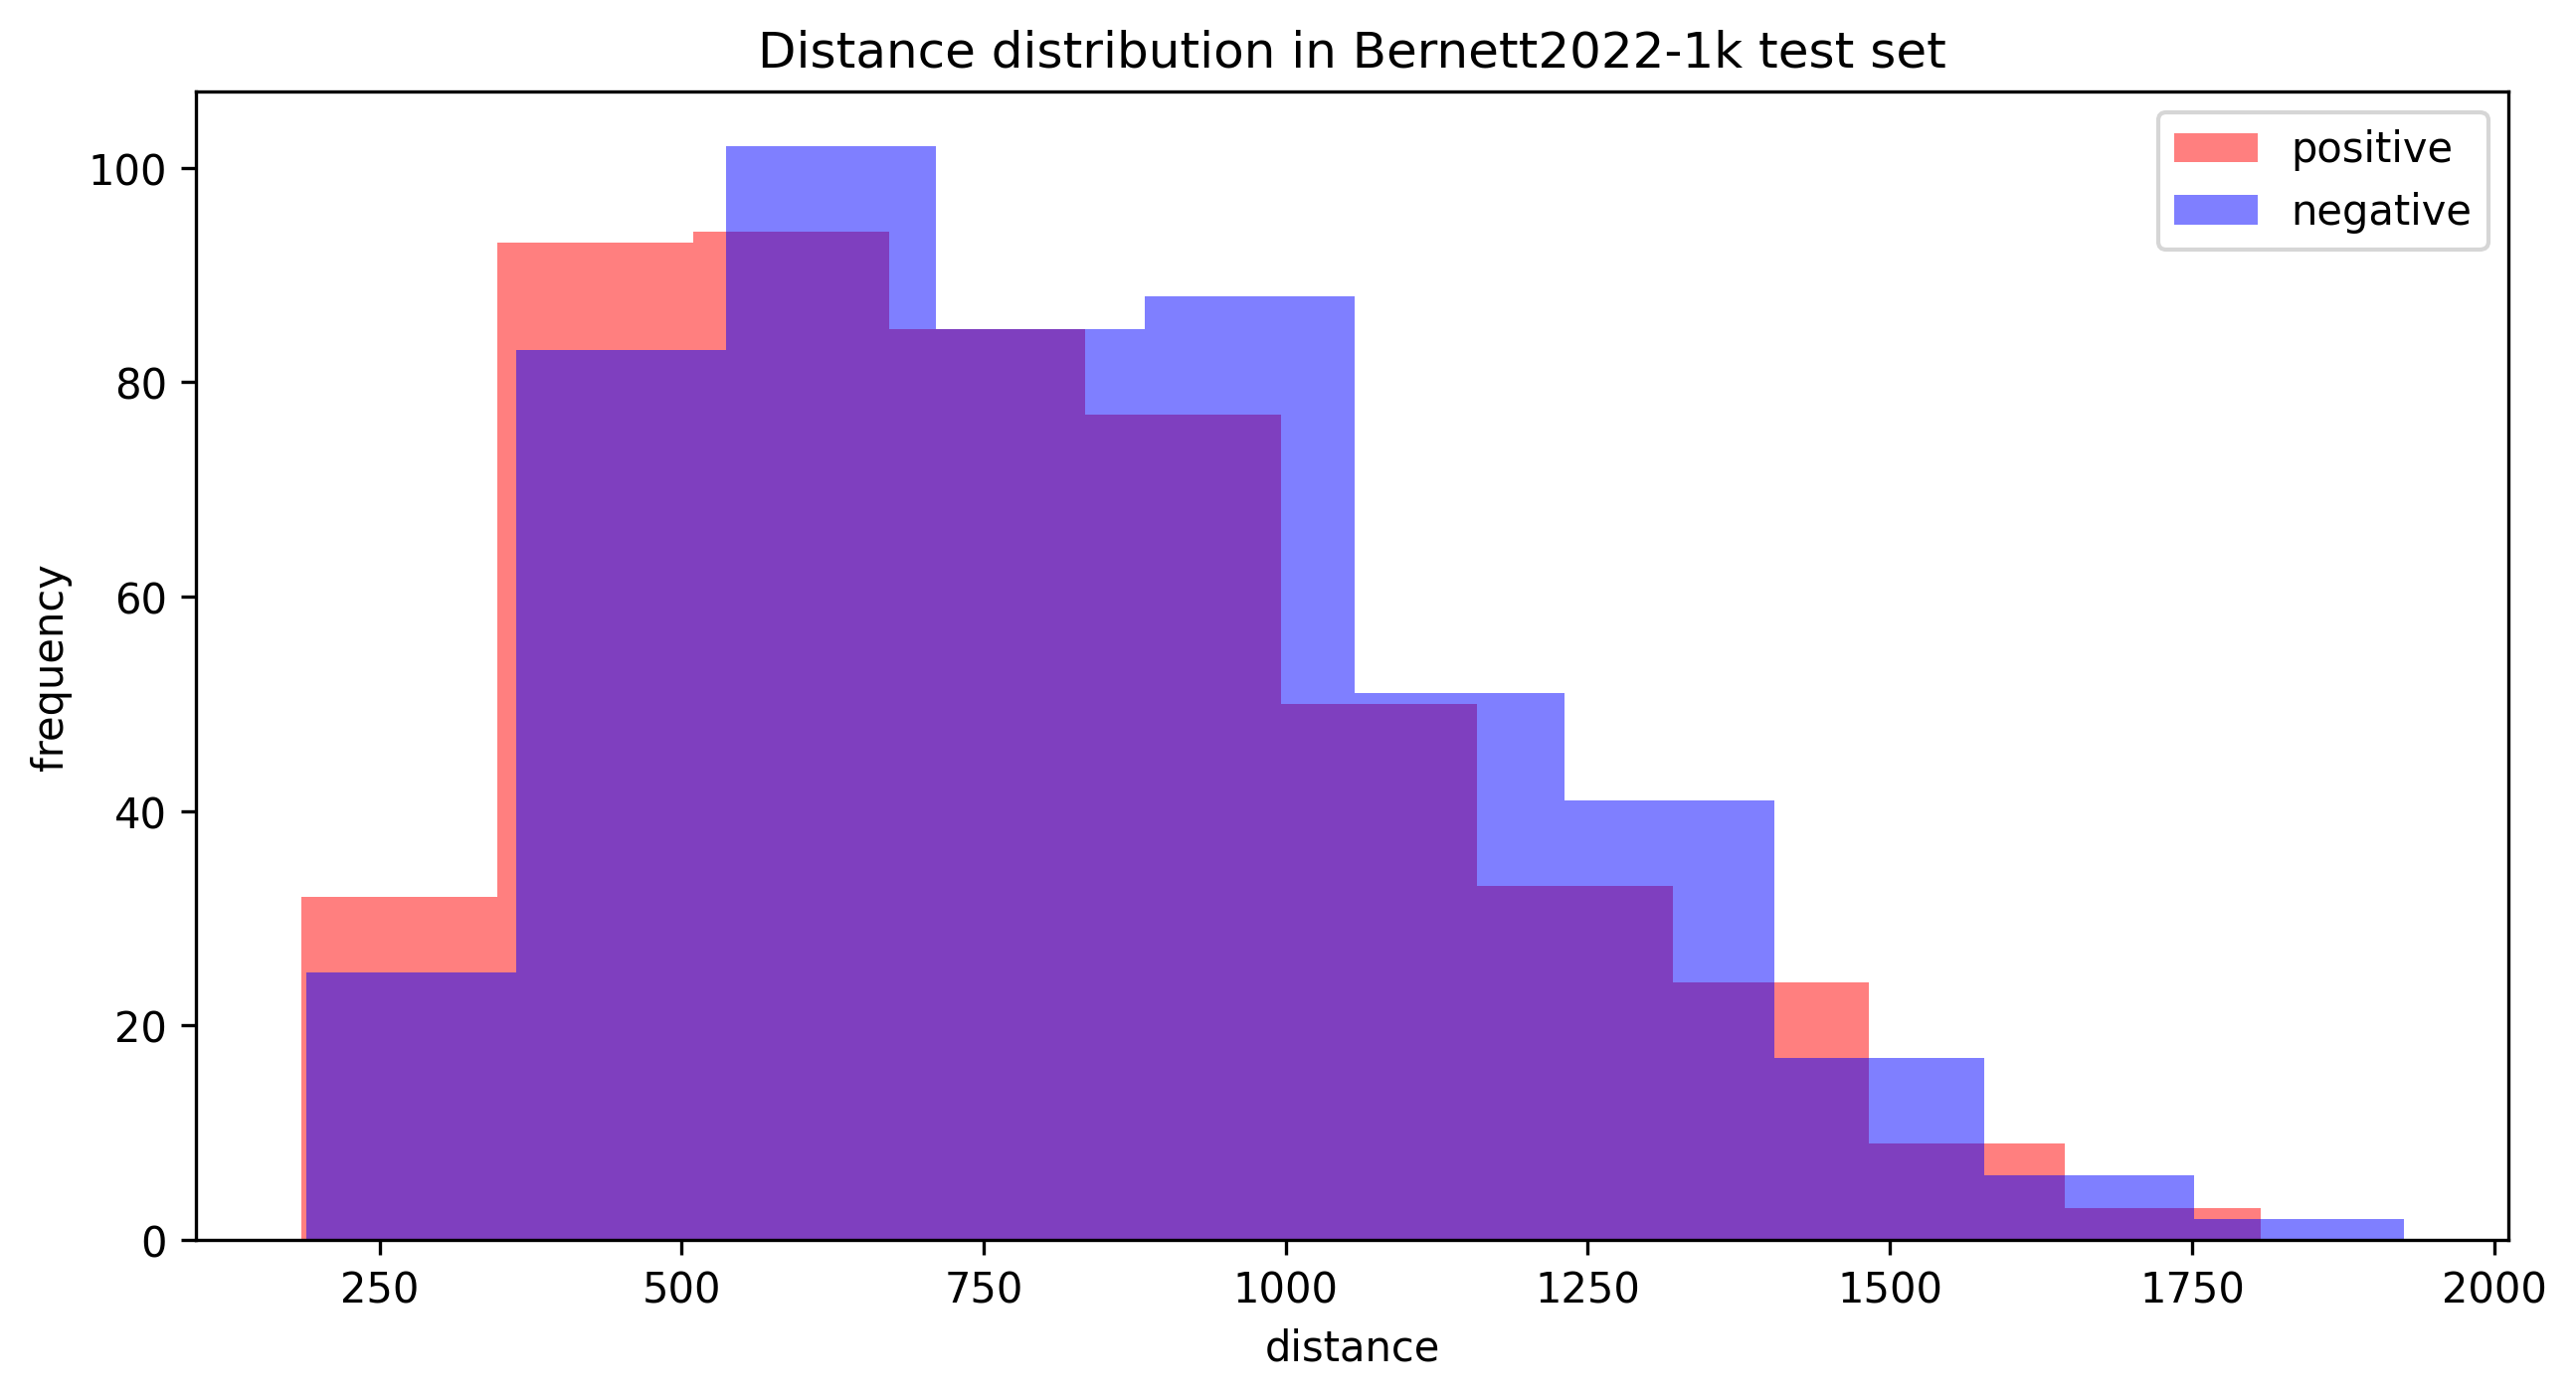

KL(1 | 0) divergence: 0.011
KL(0 | 1) divergence: 0.011


In [12]:
bernett_data_file = f"{HOME}/projects/gLM/data/Bernett2022_1k/test.txt"
bernett_emb_file = f"{HOME}/projects/gLM/embeddings/Bernett2022_1k/gLM2_650M_sep/test.pt"

bernett_pos_dists, bernett_neg_dists = get_distances(bernett_data_file, bernett_emb_file)
bernett_hist_pos, bernett_hist_neg = plot_distributions(bernett_pos_dists, 
    bernett_neg_dists, title="Distance distribution in Bernett2022-1k test set"
)

kl_posneg, kl_negpos = compute_KL_divergence(bernett_hist_pos, bernett_hist_neg)
print(f"KL(1 | 0) divergence: {kl_posneg:.3f}\nKL(0 | 1) divergence: {kl_negpos:.3f}")

In [28]:
# Counting the number of homodimers in PINDER set

pinder_seq_data = get_pinder_seq_data(pinder_data_file)
pinder_homodimers_count = get_homodimers_count(pinder_data_file, pinder_seq_data)

print(f"Fraction of homodimers in PINDER-eubacteria-species test set: {pinder_homodimers_count/len(pinder_data):.3f}")

Fraction of homodimers in PINDER-eubacteria-species test set: 0.236


In [27]:
# Counting the number of homodimers in Bernett2022-1k set

bernett_fasta = f"{HOME}/projects/gLM/data/Bernett2022/human_swissprot_oneliner.fasta"
bernett_seq_data = get_seq_data(bernett_data_file, bernett_fasta)
bernett_homodimers_count = get_homodimers_count(bernett_data_file, bernett_seq_data)

print(f"Fraction of homodimers in PINDER-eubacteria-species test set: {bernett_homodimers_count/len(bernett_data):.3f}")

Fraction of homodimers in PINDER-eubacteria-species test set: 0.000
